**Assignment 6**

[3 points] Delelop language model, which generates texts from wikipedia.
Use WikiText-2 dataset, also available in torchtext.datasets.
Use sentencepiece or tokenizers library for text tokenization. Pay attention to vocab size, probably subword tokens are better.

Your model should be autogressive RNN.

[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.

[1 point] Try to use together (sentencepiece or tokenizers), torchtext.datasets, and torchtext.data.BPTTIterator


Text generation should be terminated when either max length is reached or terminal symbol is generated.
Explore several inference techniques:

[1 point] Argmax

[1 point] Beamsearch

[1 point] Sampling from probabilty distribution with temperature

[1 point] Nucleus sampling

[1 point] Top-k sampling

For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

In [0]:
pip install tokenizers

     |████████████████████████████████| 3.7MB 9.1MB/s 


In [0]:
import pandas as pd
import numpy as np
import nltk
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchtext.data import Field, LabelField, RawField, BPTTIterator
from torchtext.datasets import WikiText2

from tokenizers import SentencePieceBPETokenizer

from tqdm import tqdm
from tqdm import tqdm_notebook

SEED = 42
np.random.seed(SEED)

In [0]:
WikiText2.download(root = '/content/gdrive/My Drive/Colab Notebooks')

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 6.55MB/s]


extracting


'/content/gdrive/My Drive/Colab Notebooks/wikitext-2/wikitext-2'

In [0]:
parts = ['train','valid','test']
new_path = '/content/gdrive/My Drive/Colab Notebooks/wikitext-2/wikitext-2'
for i in parts:
  f_name = new_path + f'/wiki.{i}.tokens'
  with open(f_name, 'r') as f:
    if i == 'train':
      train = f.read()
    elif i == 'valid':
      valid = f.read()
    elif i == 'test':
      test = f.read()

In [0]:
#let's check out all lengths
print(f'Train length = {len(train):7}')
print(f'Valid length = {len(valid):8}')
print(f'Test length  = {len(test):8}')

Train length = 10780437
Valid length =  1120192
Test length  =  1255018


In [0]:
print(f'Train unique characters = {len(set(train))}')
print(f'Valid unique characters = {len(set(valid))}')
print(f'Test unique characters  = {len(set(test))}')

Train unique characters = 283
Valid unique characters = 122
Test unique characters  = 120


In [0]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.add_special_tokens(['<unk>'])

1

In [0]:
new_path = '/content/gdrive/My Drive/Colab Notebooks/wikitext-2/wikitext-2'
train_text = new_path + '/wiki.train.tokens'
valid_text = new_path + '/wiki.valid.tokens'
test_text = new_path + '/wiki.test.tokens'
tokenizer.train([train_text, valid_text, test_text], vocab_size=10000)

In [0]:
tokenizer.encode("Hello, world ! <unk>").tokens

['▁Hell', 'o', ',', '▁world', '▁!', '▁', '<unk>']

In [0]:
def tok_func(tokenizer, text):
  return tokenizer.encode(text).tokens

In [0]:
tok_func(tokenizer, "Hello, world ! <unk>")

['▁Hell', 'o', ',', '▁world', '▁!', '▁', '<unk>']

In [0]:
TEXT = Field(lower=True, tokenize=lambda x: tok_func(tokenizer, x), include_lengths=False, batch_first=True)

In [0]:
train, valid, test = WikiText2.splits(TEXT)

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 6.64MB/s]


extracting


In [0]:
TEXT.build_vocab(train, valid, test)

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')

In [0]:
train_iter, valid_iter, test_iter = BPTTIterator.splits((train, valid, test),
    batch_size=64,
    bptt_len=30,
    repeat=False,
    device=device)

In [0]:
batch = next(iter(train_iter))
print(batch.text[:3, 0])
print(batch.target[:3, 0])

tensor([ 3, 11, 12])
tensor([  11,   12, 6854])


# Training model

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):

        if hasattr(batch, 'text'):
          x = batch.text.T
        else:
          x = batch
        
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        
        return x.transpose(1,2)

In [0]:
batch_size = 64

model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

model = model.to(device)
criterion = criterion.to(device)


In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    train_losses = []

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss, train_losses

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    n_batches = len(iterator)

    valid_losses = []

    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            epoch_loss += loss.data.item()

            valid_losses.append(loss.item())

    return epoch_loss / n_batches, valid_losses

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    all_train_losses = []
    all_valid_losses = []

    for epoch in range(n_epochs):
        train_loss, i_train_losses = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, i_valid_losses = _test_epoch(model, valid_iterator, criterion)
        all_train_losses.append(i_train_losses)
        all_valid_losses.append(i_valid_losses)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, all_train_losses, all_valid_losses

In [0]:
history_df, res_train_losses, res_valid_losses = nn_train(model, train_iter, valid_iter, criterion, optimizer, scheduler=scheduler, 
        n_epochs=5, early_stopping=2)


validation loss 2.95634



validation loss 1.46442



validation loss 0.77555



validation loss 0.47582



validation loss 0.34112


In [0]:
from sklearn.externals import joblib
joblib.dump(model, "rnn_model.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['rnn_model.pkl']

In [0]:
my_model = joblib.load("rnn_model.pkl")

# Plot

In [0]:
history_df

,epoch,train_loss,valid_loss
0,0.0,4.669927,2.956338
1,1.0,2.174097,1.464417
2,2.0,1.035408,0.775554
3,3.0,0.548122,0.475815
4,4.0,0.345170,0.341115


In [0]:
import matplotlib.pyplot as plt

In [0]:
fin_train_losses = []
for i in res_train_losses:
  for j in i:
    fin_train_losses.append(j)

In [0]:
fin_valid_losses = []
for i in res_valid_losses:
  for j in i:
    fin_valid_losses.append(j)

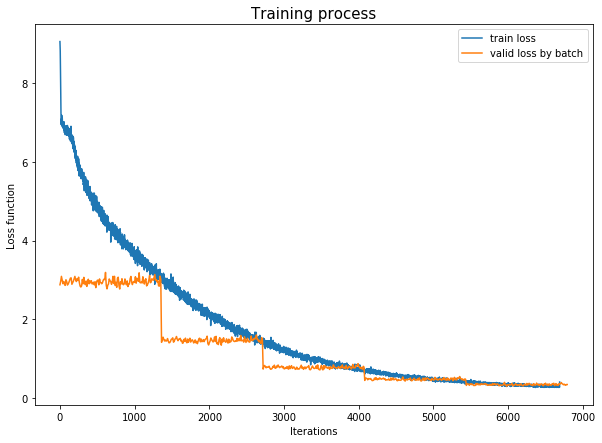

In [0]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(fin_train_losses)), fin_train_losses, np.array(range(len(fin_valid_losses)))*10, fin_valid_losses)

plt.title('Training process', fontsize=15)
plt.legend(('train loss', 'valid loss by batch'))
plt.xlabel('Iterations', fontsize=10)
plt.ylabel('Loss function', fontsize=10)

plt.show()

# Prediction

In [0]:
def num2text(sequence):
  text = [TEXT.vocab.itos[v] for v in sequence]
  return text

print(batch.text[:10, 1])
print(num2text(batch.text[:10, 1]))

tensor([   2, 3897,   31,   14,   93,  804,  129, 6604,  532,  120])
['▁the', '▁myth', 's', '▁was', '▁more', '▁important', '▁than', '▁elaborate', '▁story', 't']


In [0]:
def join_text(text_list): 
  s = num2text(text_list)
  return ''.join(s).replace('▁', ' ').strip()

In [0]:
join_text(batch.text[:10, 1])

'the myths was more important than elaborate storyt'

In [0]:
def generate(model, func, start, max_len=30, eos='<eos>'):
  token = start
  with tt.no_grad():
      seq = [token]
      i = 0
      while i < max_len and token != TEXT.vocab.stoi[eos]:
        i += 1
        pred = model(tt.tensor([seq]))[:,:,-1]
        token = func(pred)
        seq.append(token)

  return join_text(seq)

# Argmax

In [0]:
def argmax(pred):
  return tt.argmax(pred).item()

In [0]:
seed = TEXT.vocab.stoi['myths']

In [0]:
print(generate(my_model, argmax, start=seed))

<unk> , and the <unk> of the <unk> , and the <unk> of the <unk> , and the <unk> of the <unk> , and the


# Top-K Sampling

In [0]:
import torch

def top_k(pred, top_k=2):

    min_val = torch.topk(pred, top_k)[0][..., -1, None]
    extra_ids = pred < min_val
    pred[extra_ids] = -float("Inf")

    return torch.multinomial(torch.exp(pred), 1)

In [0]:
generate(my_model, top_k, start=seed)

'<unk> , and the <unk> of the <unk> , and <unk> , and <unk> , and <unk> , and the song was the first time ,'

В сравнении в аргмаксом результат стал чуть лучше

# With temperature

In [0]:
def tau_2(probs, tau=1):

  probs = probs.detach()
  dop = probs/tau
  res = tt.exp(dop)/tt.sum(tt.exp(dop))
  res = res.squeeze()
  res = res.numpy()/np.sum(res.numpy())
  result = np.random.choice(len(res), 1, p=res)[0]
  
  return result

In [0]:
generate(model, tau_2, seed)

'<unk> " dominature by the jin oxygen of four hits university that developed on in relatively charge shot late days and kick studioockay ross ( 1<eos>'

In [0]:
generate(model, tau_2, seed)

'<unk> , weafizes over specific other city were intelligence disbandon was dedicated in 1959 us north weeks he was obtained were commanded in chains in the colonies ,'

С температурой результат получился еще более интересным

# Nucleus

In [0]:
def tau_dop(probs, tau = 1):
  probs = probs.detach()
  dop = probs/tau
  res = tt.exp(dop)/tt.sum(tt.exp(dop))
  res = res.squeeze()
  if np.sum(res.numpy()) == 1:
    res = res.numpy()
  else:
    res = res.numpy()/np.sum(res.numpy())
    
  return res

In [0]:
def nucleus(probs, p = 0.5):
  cumul = 0
  num = 0

  probs = probs.detach().squeeze()
  new_probs =  tt.tensor(tau_dop(probs))
  sorted_probs = tt.argsort(new_probs, descending=True)

  while cumul < p:
    prob_id = sorted_probs[num]
    cumul += new_probs[prob_id]
    num += 1

  top_ids = sorted_probs[:num]
  top_probs = new_probs[top_ids]
  result = np.random.choice(top_ids.numpy(), 1, p=tau_dop(top_probs))[0]

  return result

In [0]:
gen_t_nucl = generate(my_model, nucleus, seed)

print(gen_t_nucl)

<unk> of a troalog in 2010 . the watershed as the whole panoners of frelimo the latter 's player 's song were left off and six


In [0]:
generate(my_model, nucleus, seed)

'<unk> . the result , they often with his longable were replaced the on some wartilian propas , including it " is from her mother'

In [244]:
generate(my_model, nucleus, seed)

'<unk> , the three companies was designated as the turks was being completed on may from 1640 ( an north – 0 in the netherlands , with aided range'

Тут уже попадается чуть меньше ненужных символов

Думаю, было бы лучше еще обучить модель на большем количестве эпох и с более качественной преобработкой.